# Comprehensive Analysis of the Big Five Canadian Banks' Stock Performance

Description:
This script performs a comprehensive analysis of the historical stock performance 
(2000-2025) of Canada's five largest banks. It includes data collection from the 
yfinance API and a predictive model using XGBoost to forecast 
30-day returns.

Author:  
* Nadia Ríos

Project for:
Data Analytics Case Study 3 (University of Niagara Falls Canada)  
Date: September 2025


### 0. Download the datasets for the Big five Canadian Banks

In [23]:
pip install yfinance

In [24]:
#Importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.ticker as mtick 
import statsmodels.api as sm

In [25]:
# Define the stock tickers for the Big Five Canadian banks on the Toronto Stock Exchange (TSX)
rbc = "RY.TO" # Royal Bank of Canada
cibc = "CM.TO" # Canadian Imperial Bank of Commerce

# Define the start and end dates
start_date = "2000-01-01"
end_date = "2025-08-28" #setting model day as the limit

rbc_data = yf.download(rbc, start=start_date, end=end_date,auto_adjust=False , multi_level_index=False)
cibc_data = yf.download(cibc, start=start_date, end=end_date, auto_adjust=False, multi_level_index=False)
                     
print("Royal Bank of Canada Stock Data:\n" , rbc_data.head())
print("\nCanadian Imperial Bank of Commerce Stock Data:\n", cibc_data.head())

# Save the data to a CSV file
#rbc_data.to_csv("RBC_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Royal Bank of Canada Stock Data:
             Adj Close    Close   High      Low    Open   Volume
Date                                                           
2000-01-04   6.024874  15.4375  15.75  15.2750  15.750  3963200
2000-01-05   6.000482  15.3750  15.55  15.3500  15.475  4668800
2000-01-06   6.088292  15.6000  15.75  15.2000  15.250  2284400
2000-01-07   6.029752  15.4500  15.60  15.2250  15.600  3456000
2000-01-10   5.941938  15.2250  15.50  15.0875  15.300  2426400

Canadian Imperial Bank of Commerce Stock Data:
             Adj Close      Close       High        Low    Open   Volume
Date                                                                   
2000-01-04   5.384400  16.700001  16.799999  16.350000  16.650  2796800
2000-01-05   5.424701  16.825001  17.075001  16.424999  16.525  2852800
2000-01-06   5.432763  16.850000  17.075001  16.650000  16.750  2411200
2000-01-07   5.432763  16.850000  16.850000  16.375000  16.850  1833000
2000-01-10   5.319915  16.500000  16.

## I. RBC Model

In [26]:
rbc_data

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2000-01-04,6.024874,15.437500,15.750000,15.275000,15.750000,3963200
2000-01-05,6.000482,15.375000,15.550000,15.350000,15.475000,4668800
2000-01-06,6.088292,15.600000,15.750000,15.200000,15.250000,2284400
2000-01-07,6.029752,15.450000,15.600000,15.225000,15.600000,3456000
2000-01-10,5.941938,15.225000,15.500000,15.087500,15.300000,2426400
...,...,...,...,...,...,...
2025-08-21,189.410004,189.410004,190.039993,188.880005,188.960007,3947800
2025-08-22,190.649994,190.649994,191.220001,189.279999,189.860001,4241400
2025-08-25,188.880005,188.880005,190.679993,188.740005,190.419998,1943000


In [27]:
rbc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6444 entries, 2000-01-04 to 2025-08-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  6444 non-null   float64
 1   Close      6444 non-null   float64
 2   High       6444 non-null   float64
 3   Low        6444 non-null   float64
 4   Open       6444 non-null   float64
 5   Volume     6444 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 352.4 KB


### 1. Data preparation for the RBC model

In [28]:
# --- Step 1: Define Constants and Initial Calculations ---
print("Step 1: Defining constants and calculating core metrics...")

# Define the forecasting horizon for the target variable
forecast_horizon = 30

# Calculate the core metric: Daily Percentage Return using 'Adj Close'
# 'Adj Close' is used for returns as it accounts for dividends and splits.
daily_return = rbc_data['Adj Close'].pct_change()

# --- Step 2: Create the Target Variable (y) ---
# The target is the 30-day future return percentage.
print("Step 2: Creating the target variable (y)...")

target = (
    rbc_data['Adj Close'].shift(-forecast_horizon) / rbc_data['Adj Close']
) - 1

# Rename for clarity
target.name = f'target_{forecast_horizon}d_return'

# --- Step 3: Initialize and Build the Feature DataFrame (X) ---
# We will now create all 34 features.
print("Step 3: Building the feature matrix (X)...")

# Initialize a new DataFrame to hold all the features
features = pd.DataFrame(index=rbc_data.index)

# --- Group A: Original 16 Features ---
print("  - Creating original 16 features...")
# Time-Based Features
# features['year'] = rbc_data.index.year #performs better without year
features['month'] = rbc_data.index.month
features['day_of_week'] = rbc_data.index.dayofweek
features['quarter'] = rbc_data.index.quarter

# Return Lag Features (based on daily returns)
for i in range(1, 11):
    features[f'return_lag_{i}'] = daily_return.shift(i)

# Return Moving Average (Trend) Features
features['return_ma_7'] = daily_return.rolling(window=7).mean()
features['return_ma_20'] = daily_return.rolling(window=20).mean()
features['return_ma_30'] = daily_return.rolling(window=30).mean()
features['return_ma_50'] = daily_return.rolling(window=50).mean()

# Return Volatility (Risk) Feature
features['volatility_7'] = daily_return.rolling(window=7).std()
features['volatility_30'] = daily_return.rolling(window=30).std()
features['volatility_60'] = daily_return.rolling(window=60).std()

# --- Group B: New 18 Technical Indicators ---
print("  - Creating 18 new technical indicator features...")
# Daily Price Range & Difference Features
features['high_low_range'] = (rbc_data['High'] - rbc_data['Low']) / rbc_data['Close']
features['open_close_diff'] = (rbc_data['Close'] - rbc_data['Open']) / rbc_data['Open']
features['close_high_ratio'] = (rbc_data['High'] - rbc_data['Close']) / rbc_data['Close']
features['close_low_ratio'] = (rbc_data['Close'] - rbc_data['Low']) / rbc_data['Close']

# Volume-Based Features
features['volume_lag_1'] = rbc_data['Volume'].shift(1)
features['volume_ma_7'] = rbc_data['Volume'].rolling(window=7).mean()
features['volume_ma_30'] = rbc_data['Volume'].rolling(window=30).mean()
features['volume_change'] = rbc_data['Volume'].pct_change()
features['volume_price_trend'] = daily_return * rbc_data['Volume']

# Intraday & Overnight Return Features
features['overnight_return'] = (rbc_data['Open'] - rbc_data['Close'].shift(1)) / rbc_data['Close'].shift(1)
features['intraday_return'] = (rbc_data['Close'] - rbc_data['Open']) / rbc_data['Open']

# Candlestick Shadow Features
features['candle_upp_shadow'] = (rbc_data['High'] - np.maximum(rbc_data['Open'], rbc_data['Close'])) / rbc_data['Close']
features['candle_low_shadow'] = (np.minimum(rbc_data['Open'], rbc_data['Close']) - rbc_data['Low']) / rbc_data['Close']

# Complex Indicators: RSI and MACD
# RSI (14 days)
delta = rbc_data['Adj Close'].diff(1)         # daily price change
gain = delta.where(delta > 0, 0)              # keep positive changes
loss = -delta.where(delta < 0, 0)             # keep absolute value of negative changes
avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
rs = avg_gain / avg_loss                      # relative strength
features['RSI_14days'] = 100 - (100 / (1 + rs))


# MACD
ema_12 = rbc_data['Adj Close'].ewm(span=12, adjust=False).mean()   # fast moving average
ema_26 = rbc_data['Adj Close'].ewm(span=26, adjust=False).mean()   # slow moving average
features['MACD'] = ema_12 - ema_26                                 # trend strength
features['MACD_signal'] = features['MACD'].ewm(span=9, adjust=False).mean()

# --- Step 4: Combine, Clean, and Finalize ---
print("Step 4: Combining features and target, and cleaning the dataset...")

# Join the features with our target variable
combined_data = features.join(target)
print(f"Shape of combined data BEFORE cleaning: {combined_data.shape}")

# Drop all rows with any NaN values to get the final, clean training dataset.
# This removes rows from the beginning (due to lookback windows) and the end
# (due to the look-forward target).
cleaned_data = combined_data.dropna()
print(f"Shape of combined data AFTER cleaning: {cleaned_data.shape}")

# --- Step 5: Final Separation into X and y ---
print("Step 5: Separating into final X and y objects...")

# The features matrix X
X_rbc = cleaned_data.drop(columns=[f'target_{forecast_horizon}d_return'])

# The target vector y
y_rbc = cleaned_data[f'target_{forecast_horizon}d_return']

print("\n--- Data Preparation Complete for RBC ---")
print(f"Final shape of feature matrix (X_rbc): {X_rbc.shape}")
print(f"Final shape of target vector (y_rbc): {y_rbc.shape}")

# Inspect the final objects
print("\nSample of y_rbc (Target):")
print(y_rbc.head())
print("\nSample of X_rbc (Features):")
print(X_rbc.head())

Step 1: Defining constants and calculating core metrics...
Step 2: Creating the target variable (y)...
Step 3: Building the feature matrix (X)...
  - Creating original 16 features...
  - Creating 18 new technical indicator features...
Step 4: Combining features and target, and cleaning the dataset...
Shape of combined data BEFORE cleaning: (6444, 37)
Shape of combined data AFTER cleaning: (6354, 37)
Step 5: Separating into final X and y objects...

--- Data Preparation Complete for RBC ---
Final shape of feature matrix (X_rbc): (6354, 36)
Final shape of target vector (y_rbc): (6354,)

Sample of y_rbc (Target):
Date
2000-03-28    0.119281
2000-03-29    0.104523
2000-03-30    0.048291
2000-03-31    0.118626
2000-04-03    0.079060
Name: target_30d_return, dtype: float64

Sample of X_rbc (Features):
            month  day_of_week  quarter  return_lag_1  return_lag_2  \
Date                                                                  
2000-03-28      3            1        1     -0.0166

In [29]:
X_rbc.columns


Index(['month', 'day_of_week', 'quarter', 'return_lag_1', 'return_lag_2',
       'return_lag_3', 'return_lag_4', 'return_lag_5', 'return_lag_6',
       'return_lag_7', 'return_lag_8', 'return_lag_9', 'return_lag_10',
       'return_ma_7', 'return_ma_20', 'return_ma_30', 'return_ma_50',
       'volatility_7', 'volatility_30', 'volatility_60', 'high_low_range',
       'open_close_diff', 'close_high_ratio', 'close_low_ratio',
       'volume_lag_1', 'volume_ma_7', 'volume_ma_30', 'volume_change',
       'volume_price_trend', 'overnight_return', 'intraday_return',
       'candle_upp_shadow', 'candle_low_shadow', 'RSI_14days', 'MACD',
       'MACD_signal'],
      dtype='object')

About the shape changes:  
1. Loss at the Beginning (Warm-up): The new feature Rolling Volatility 60 requires a 60-day lookback window. This is now the longest historical requirement. Therefore, the first 60 rows of your data cannot have a complete set of features and will be dropped.  
2. Loss at the End (Horizon): The target variable requires looking 30 days into the future. Therefore, the last 30 rows of your data will not have a target value and will be dropped.
* Total Expected Rows Lost: 60 (from the start) + 30 (from the end) = 90 rows.
* Expected Final Shape: 6444 - 90 = 6354 rows.

### 2. Model Training and Evaluation

In [30]:
#installing xgboost
!pip install xgboost

Step 1: Splitting data into training and testing sets...
Training set shape: (5400, 36)
 → Date range: 2000-03-28 to 2021-09-24
Testing set shape: (954, 36)
 → Date range: 2021-09-27 to 2025-07-15

Step 2: Training the XGBoost model...
Model training complete.

Step 3: Making predictions on the unseen test data...

Step 4: Evaluating model performance...
Root Mean Squared Error (RMSE): 0.0546
  - Interpretation: On average, the model's prediction for the 30-day return was off by about 5.46%.
Mean Absolute Error (MAE): 0.0443
  - Interpretation: Another view of the average error, also about 4.43%.
R-squared (R²): 0.0355
  - Interpretation: The model explains about 3.5% of the variance in the 30-day future returns.

Step 5: Analyzing feature importance...


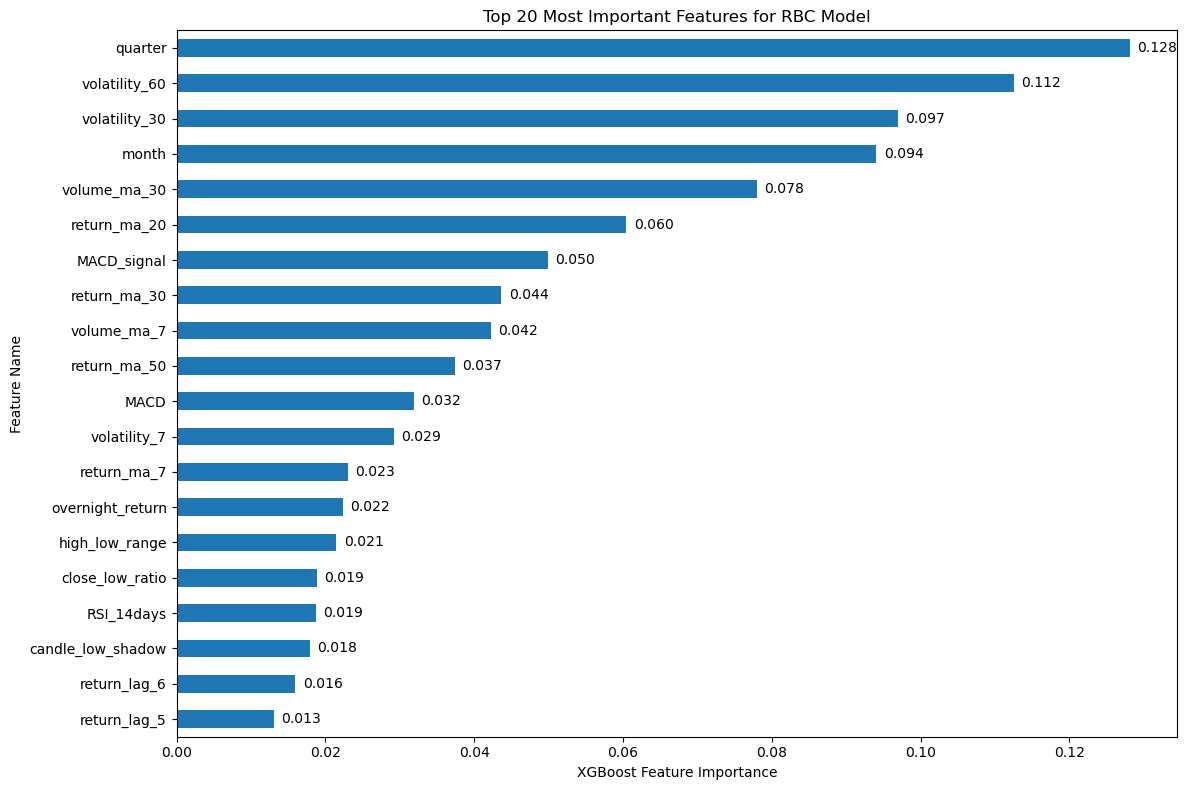

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Split the Data into Training and Testing Sets ---
print("Step 1: Splitting data into training and testing sets...")

# We use an 80/20 split. 80% of the data will be used to train the model,
# and the final 20% will be used to test its performance on unseen data.
# CRITICAL: shuffle=False is used because this is time-series data. We must
# preserve the chronological order, training on the past and testing on the most recent data.
X_train, X_test, y_train, y_test = train_test_split(X_rbc, y_rbc, test_size=0.15, shuffle=False, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f" → Date range: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"Testing set shape: {X_test.shape}")
print(f" → Date range: {X_test.index.min().date()} to {X_test.index.max().date()}")

# --- Step 2: Initialize and Train the XGBoost Regressor Model ---
print("\nStep 2: Training the XGBoost model...")

# We initialize the model with a set of powerful hyperparameters.
# n_estimators=1000: The model can build up to 1000 decision trees.
# learning_rate=0.05: A small learning rate helps the model generalize better.
# early_stopping_rounds=10: This is a crucial optimization. If the model's
#   performance on the test set doesn't improve for 10 consecutive trees,
#   training will stop automatically to prevent overfitting.
# random_state=42: Ensures that you get the same results every time you run the code.
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,  # Control tree depth
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='reg:squarederror',
    early_stopping_rounds=10,
    n_jobs=-1,  # Use all available CPU cores to speed up training
    random_state=42
)

# Train the model on the training data.
# We provide the test set as an evaluation set for the early stopping mechanism.
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False) # Set to True if you want to see the training progress

print("Model training complete.")

# --- Step 3: Make Predictions on the Test Set ---
print("\nStep 3: Making predictions on the unseen test data...")
predictions = model.predict(X_test)

# --- Step 4: Evaluate Model Performance ---
print("\nStep 4: Evaluating model performance...")

# We use several standard regression metrics to evaluate the model.
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  - Interpretation: On average, the model's prediction for the 30-day return was off by about {rmse:.2%}.")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"  - Interpretation: Another view of the average error, also about {mae:.2%}.")
print(f"R-squared (R²): {r2:.4f}")
print(f"  - Interpretation: The model explains about {r2:.1%} of the variance in the 30-day future returns.")

# --- Step 5: Analyze Feature Importance ---
# This step is crucial for your report to explain what drives the predictions.
print("\nStep 5: Analyzing feature importance...")

# Create a pandas Series for easy plotting
feature_importance = pd.Series(model.feature_importances_, index=X_rbc.columns)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
feature_importance.nlargest(20).sort_values().plot(kind='barh')
ax = feature_importance.nlargest(20).sort_values().plot(kind='barh')
plt.title('Top 20 Most Important Features for RBC Model')
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature Name')
# Add value labels
for i, v in enumerate(feature_importance.nlargest(20).sort_values()):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

Table 4.3.1: Baseline Model Performance (RBC, 36 Features)
| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| RMSE | 0.0546 | The model's predictions were off by an average of 5.46%. |
| MAE | 0.0443 | The model's predictions were off by an average of 4.43%. |
| R-squared | 0.0355 | The model explained approximately 3.5% of the variance in future returns. |

In [32]:
X_rbc.shape

(6354, 36)

Selecting top 15 variables:

--- Starting Feature Selection Experiment ---

Top 15 features selected for the new model:
['quarter', 'volatility_60', 'volatility_30', 'month', 'volume_ma_30', 'return_ma_20', 'MACD_signal', 'return_ma_30', 'volume_ma_7', 'return_ma_50', 'MACD', 'volatility_7', 'return_ma_7', 'overnight_return', 'high_low_range']

New feature matrix shape: (6354, 15)

Training new model with selected features...
Training complete.

Evaluating new model performance...

--- Performance Comparison ---
                          Original Model (36 Features)   |   New Model (Top 15 Features)
Root Mean Squared Error:    0.0546                       |   0.0549
Mean Absolute Error (MAE):  0.0443                       |   0.0442
R-squared (R²):             0.0355  (3.5%)               |   0.0269  (2.7%)


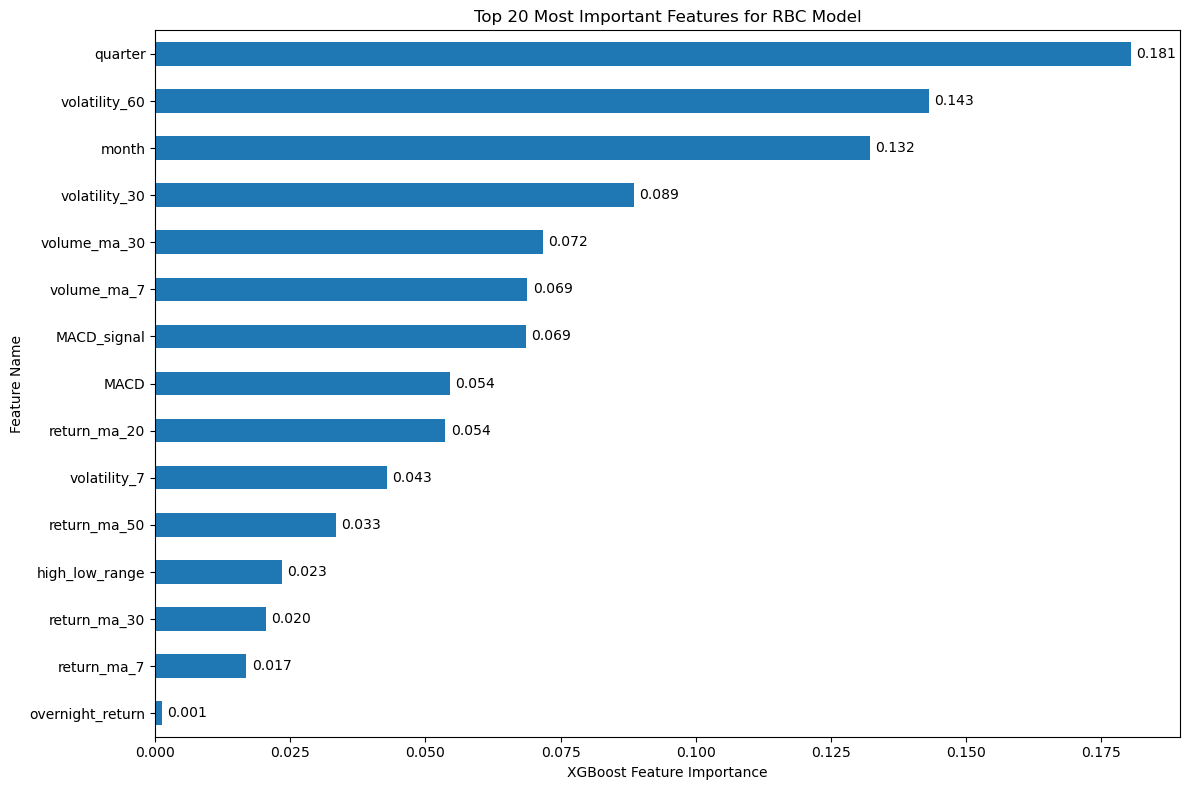

In [33]:
# --- This code assumes you have just run your previous script and have these objects: ---
# model: The already trained XGBoost model
# X_rbc: The full feature matrix (36 features)
# y_rbc: The target vector

print("--- Starting Feature Selection Experiment ---")

# --- Step 1: Identify the Top 15 Most Important Features ---
feature_importance = pd.Series(model.feature_importances_, index=X_rbc.columns)
top_15_features = feature_importance.nlargest(15).index.tolist()

print("\nTop 15 features selected for the new model:")
print(top_15_features)

# --- Step 2: Create the New Feature Matrix ---
X_rbc_selected = X_rbc[top_15_features]

print(f"\nNew feature matrix shape: {X_rbc_selected.shape}")

# --- Step 3: Rerun the Model Training and Evaluation with Selected Features ---

# a) Split the new, smaller dataset
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_rbc_selected, y_rbc, test_size=0.15, shuffle=False, random_state=42
)

# b) Initialize a new model
model_selected = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,  # Control tree depth
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='reg:squarederror',
    early_stopping_rounds=10,
    n_jobs=-1,  # Use all available CPU cores to speed up training
    random_state=42
)

# c) Train the new model
print("\nTraining new model with selected features...")
model_selected.fit(X_train_sel, y_train_sel,
                   eval_set=[(X_test_sel, y_test_sel)],
                   verbose=False)
print("Training complete.")

# d) Evaluate the new model
print("\nEvaluating new model performance...")
predictions_selected = model_selected.predict(X_test_sel)
rmse_selected = np.sqrt(mean_squared_error(y_test_sel, predictions_selected))
mae_selected = mean_absolute_error(y_test_sel, predictions_selected)
r2_selected = r2_score(y_test_sel, predictions_selected)

print("\n--- Performance Comparison ---")
print("                          Original Model (36 Features)   |   New Model (Top 15 Features)")
print(f"Root Mean Squared Error:    {rmse:.4f}                       |   {rmse_selected:.4f}")
print(f"Mean Absolute Error (MAE):  {mae:.4f}                       |   {mae_selected:.4f}")
print(f"R-squared (R²):             {r2:.4f}  ({r2:.1%})               |   {r2_selected:.4f}  ({r2_selected:.1%})")

# Create a pandas Series for easy plotting
feature_importance = pd.Series(model_selected.feature_importances_, index=X_rbc_selected.columns)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
feature_importance.sort_values().plot(kind='barh')
ax = feature_importance.sort_values().plot(kind='barh')
plt.title('Top 20 Most Important Features for RBC Model')
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature Name')
# Add value labels
for i, v in enumerate(feature_importance.sort_values()):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

Table 4.3.2: Performance Comparison of RBC Models (15% Test Split)
| Metric | Original Model (36 Features) | Optimized Model (Top 15 Features) |
| :--- | :--- | :--- |
| RMSE | 0.0546 | 0.0549 |
| MAE | 0.0443 | 0.0442 |
| R-squared| 0.0355 (3.5%)| 0.0269 (2.7%) |

### 3. Deployment: Updating final steps after refining the training model


Step 5: Analyzing feature importance for the optimized 15-feature model...


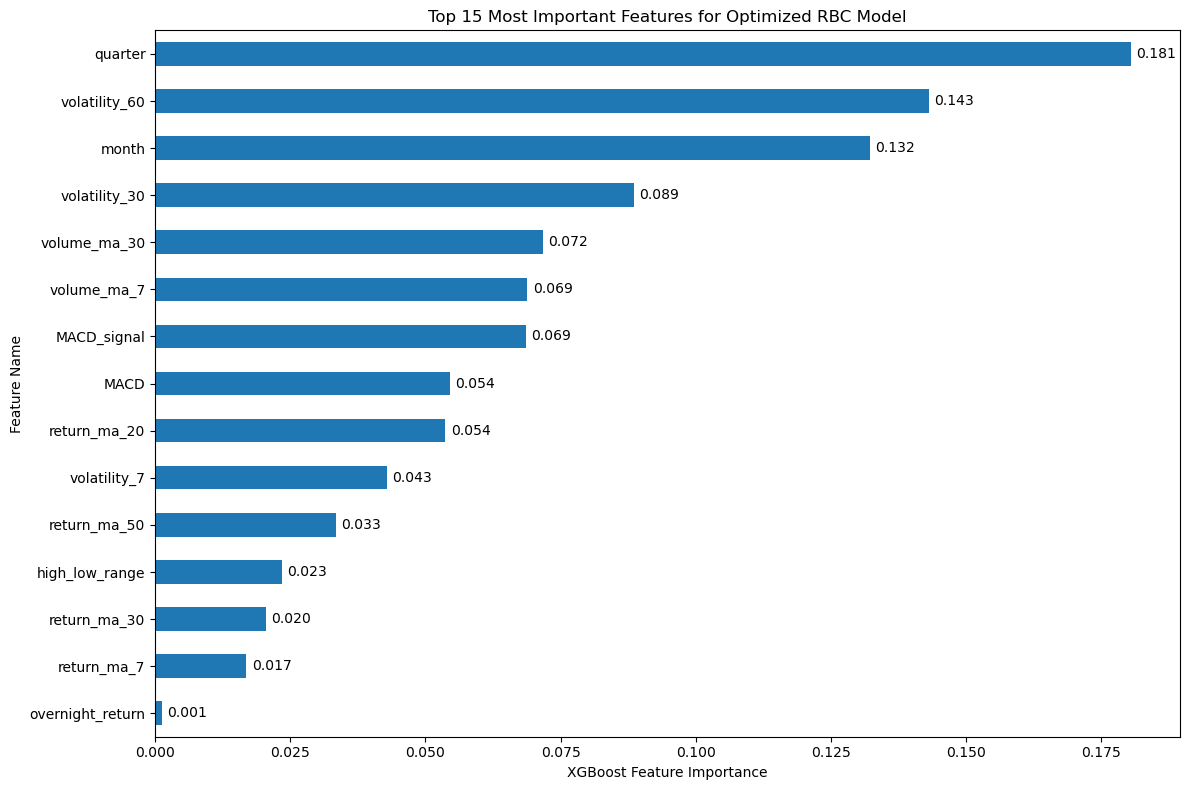


Step 6: Generating the final 30-day forecast using the optimized 15-feature model...
  - Retraining the optimized 15-feature model on 100% of the data...

---------------------------------------------------
           FINAL RBC FORECAST (Optimized Model)
---------------------------------------------------
The model predicts a return of: 8.33%
over the next 30 days for Royal Bank of Canada (RY.TO).
---------------------------------------------------


In [34]:
# --- Step 5: Analyze Feature Importance of the Optimized Model ---
print("\nStep 5: Analyzing feature importance for the optimized 15-feature model...")

# Create a pandas Series for easy plotting
# CORRECTED: The index must match the features the model was trained on.
feature_importance = pd.Series(model_selected.feature_importances_, index=X_rbc_selected.columns)

# Plot the top 15 most important features
plt.figure(figsize=(12, 8))
# Since we only have 15 features, nlargest(15) will show all of them.
ax = feature_importance.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Most Important Features for Optimized RBC Model')
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature Name')

# Add value labels for clarity
for i, v in enumerate(feature_importance.nlargest(15).sort_values()):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

# --- Step 6: Generate the Final, Actionable Forecast with the CHAMPION Model ---
print("\nStep 6: Generating the final 30-day forecast using the optimized 15-feature model...")

# To get the most accurate possible forecast, we retrain our champion model
# on ALL available data (both training and testing sets).
print("  - Retraining the optimized 15-feature model on 100% of the data...")

# Use the same tuned hyperparameters from your best model
final_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# CORRECTED: We must retrain our champion model on the selected features.
# Fitting on X_rbc_selected ensures we are using the 15-feature structure.
final_model.fit(X_rbc_selected, y_rbc, verbose=False)

# Get the most recent row of data from our SELECTED feature matrix.
# This represents "today" with the 15-feature structure.
last_known_features = X_rbc_selected.iloc[[-1]]

# Use the fully trained, optimized model to predict the 30-day return.
final_forecast_rbc = final_model.predict(last_known_features)[0]

print("\n---------------------------------------------------")
print("           FINAL RBC FORECAST (Optimized Model)")
print("---------------------------------------------------")
print(f"The model predicts a return of: {final_forecast_rbc:.2%}")
print("over the next 30 days for Royal Bank of Canada (RY.TO).")
print("---------------------------------------------------")

## II: CIBC Model

### 1. Data preparation for the RBC model

In [35]:
# --- Step 1: Define Constants and Initial Calculations ---
print("Step 1: Defining constants and calculating core metrics...")

# Define the forecasting horizon for the target variable
forecast_horizon = 30

# Calculate the core metric: Daily Percentage Return using 'Adj Close'
# 'Adj Close' is used for returns as it accounts for dividends and splits.
daily_return = cibc_data['Adj Close'].pct_change()

# --- Step 2: Create the Target Variable (y) ---
# The target is the 30-day future return percentage.
print("Step 2: Creating the target variable (y)...")

target = (
    cibc_data['Adj Close'].shift(-forecast_horizon) / cibc_data['Adj Close']
) - 1

# Rename for clarity
target.name = f'target_{forecast_horizon}d_return'

# --- Step 3: Initialize and Build the Feature DataFrame (X) ---
# We will now create all 34 features.
print("Step 3: Building the feature matrix (X)...")

# Initialize a new DataFrame to hold all the features
features = pd.DataFrame(index=cibc_data.index)

# --- Group A: Original 16 Features ---
print("  - Creating original 16 features...")
# Time-Based Features
# features['year'] = cibc_data.index.year #performs better without year
features['month'] = cibc_data.index.month
features['day_of_week'] = cibc_data.index.dayofweek
features['quarter'] = cibc_data.index.quarter

# Return Lag Features (based on daily returns)
for i in range(1, 11):
    features[f'return_lag_{i}'] = daily_return.shift(i)

# Return Moving Average (Trend) Features
features['return_ma_7'] = daily_return.rolling(window=7).mean()
features['return_ma_20'] = daily_return.rolling(window=20).mean()
features['return_ma_30'] = daily_return.rolling(window=30).mean()
features['return_ma_50'] = daily_return.rolling(window=50).mean()

# Return Volatility (Risk) Feature
features['volatility_7'] = daily_return.rolling(window=7).std()
features['volatility_30'] = daily_return.rolling(window=30).std()
features['volatility_60'] = daily_return.rolling(window=60).std()

# --- Group B: New 18 Technical Indicators ---
print("  - Creating 18 new technical indicator features...")
# Daily Price Range & Difference Features
features['high_low_range'] = (cibc_data['High'] - cibc_data['Low']) / cibc_data['Close']
features['open_close_diff'] = (cibc_data['Close'] - cibc_data['Open']) / cibc_data['Open']
features['close_high_ratio'] = (cibc_data['High'] - cibc_data['Close']) / cibc_data['Close']
features['close_low_ratio'] = (cibc_data['Close'] - cibc_data['Low']) / cibc_data['Close']

# Volume-Based Features
features['volume_lag_1'] = cibc_data['Volume'].shift(1)
features['volume_ma_7'] = cibc_data['Volume'].rolling(window=7).mean()
features['volume_ma_30'] = cibc_data['Volume'].rolling(window=30).mean()
features['volume_change'] = cibc_data['Volume'].pct_change()
features['volume_price_trend'] = daily_return * cibc_data['Volume']

# Intraday & Overnight Return Features
features['overnight_return'] = (cibc_data['Open'] - cibc_data['Close'].shift(1)) / cibc_data['Close'].shift(1)
features['intraday_return'] = (cibc_data['Close'] - cibc_data['Open']) / cibc_data['Open']

# Candlestick Shadow Features
features['candle_upp_shadow'] = (cibc_data['High'] - np.maximum(cibc_data['Open'], cibc_data['Close'])) / cibc_data['Close']
features['candle_low_shadow'] = (np.minimum(cibc_data['Open'], cibc_data['Close']) - cibc_data['Low']) / cibc_data['Close']

# Complex Indicators: RSI and MACD
# RSI (14 days)
delta = cibc_data['Adj Close'].diff(1)         # daily price change
gain = delta.where(delta > 0, 0)              # keep positive changes
loss = -delta.where(delta < 0, 0)             # keep absolute value of negative changes
avg_gain = gain.ewm(alpha=1/14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False).mean()
rs = avg_gain / avg_loss                      # relative strength
features['RSI_14days'] = 100 - (100 / (1 + rs))


# MACD
ema_12 = cibc_data['Adj Close'].ewm(span=12, adjust=False).mean()   # fast moving average
ema_26 = cibc_data['Adj Close'].ewm(span=26, adjust=False).mean()   # slow moving average
features['MACD'] = ema_12 - ema_26                                 # trend strength
features['MACD_signal'] = features['MACD'].ewm(span=9, adjust=False).mean()

# --- Step 4: Combine, Clean, and Finalize ---
print("Step 4: Combining features and target, and cleaning the dataset...")

# Join the features with our target variable
combined_data = features.join(target)
print(f"Shape of combined data BEFORE cleaning: {combined_data.shape}")

#    Explicitly replace any infinite values created during feature engineering
#    with the standard missing value marker, NaN.
combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Replaced infinite values with NaN.")

# Drop all rows with any NaN values to get the final, clean training dataset.
# This removes rows from the beginning (due to lookback windows) and the end
# (due to the look-forward target).
cleaned_data = combined_data.dropna()
print(f"Shape of combined data AFTER cleaning: {cleaned_data.shape}")

# --- Step 5: Final Separation into X and y ---
print("Step 5: Separating into final X and y objects...")

# The features matrix X
X_cibc = cleaned_data.drop(columns=[f'target_{forecast_horizon}d_return'])

# The target vector y
y_cibc = cleaned_data[f'target_{forecast_horizon}d_return']

print("\n--- Data Preparation Complete for cibc ---")
print(f"Final shape of feature matrix (X_cibc): {X_cibc.shape}")
print(f"Final shape of target vector (y_cibc): {y_cibc.shape}")

# Inspect the final objects
print("\nSample of y_cibc (Target):")
print(y_cibc.head())
print("\nSample of X_cibc (Features):")
print(X_cibc.head())

Step 1: Defining constants and calculating core metrics...
Step 2: Creating the target variable (y)...
Step 3: Building the feature matrix (X)...
  - Creating original 16 features...
  - Creating 18 new technical indicator features...
Step 4: Combining features and target, and cleaning the dataset...
Shape of combined data BEFORE cleaning: (6444, 37)
Replaced infinite values with NaN.
Shape of combined data AFTER cleaning: (6353, 37)
Step 5: Separating into final X and y objects...

--- Data Preparation Complete for cibc ---
Final shape of feature matrix (X_cibc): (6353, 36)
Final shape of target vector (y_cibc): (6353,)

Sample of y_cibc (Target):
Date
2000-03-28   -0.053334
2000-03-29   -0.045122
2000-03-30   -0.086289
2000-03-31   -0.014475
2000-04-03   -0.013157
Name: target_30d_return, dtype: float64

Sample of X_cibc (Features):
            month  day_of_week  quarter  return_lag_1  return_lag_2  \
Date                                                                  
2000-03-28 

In [36]:
X_cibc.columns


Index(['month', 'day_of_week', 'quarter', 'return_lag_1', 'return_lag_2',
       'return_lag_3', 'return_lag_4', 'return_lag_5', 'return_lag_6',
       'return_lag_7', 'return_lag_8', 'return_lag_9', 'return_lag_10',
       'return_ma_7', 'return_ma_20', 'return_ma_30', 'return_ma_50',
       'volatility_7', 'volatility_30', 'volatility_60', 'high_low_range',
       'open_close_diff', 'close_high_ratio', 'close_low_ratio',
       'volume_lag_1', 'volume_ma_7', 'volume_ma_30', 'volume_change',
       'volume_price_trend', 'overnight_return', 'intraday_return',
       'candle_upp_shadow', 'candle_low_shadow', 'RSI_14days', 'MACD',
       'MACD_signal'],
      dtype='object')

### 2. Model Training and Evaluation

In [ ]:
#installing xgboost
!pip install xgboost

In [37]:
# --- DIAGNOSTIC CODE ---
# Place this after your data preparation and before your train/test split

print("Checking for infinite values in the CIBC dataset...")

# Check the features (X_cibc)
infinite_cols_X = X_cibc.columns[np.isinf(X_cibc).any()]
if len(infinite_cols_X) > 0:
    print(f"\nInfinite values found in these feature columns: {list(infinite_cols_X)}")
    # To see the exact rows with the problem:
    # print(X_cibc[X_cibc.isin([np.inf, -np.inf]).any(axis=1)])
else:
    print("\nNo infinite values found in the feature matrix (X_cibc).")

# Check the target (y_cibc)
if np.isinf(y_cibc).any():
    print("\nInfinite values found in the target vector (y_cibc)!")
else:
    print("No infinite values found in the target vector (y_cibc).")

Checking for infinite values in the CIBC dataset...

No infinite values found in the feature matrix (X_cibc).
No infinite values found in the target vector (y_cibc).


Step 1: Splitting data into training and testing sets...
Training set shape: (5400, 36)
 → Date range: 2000-03-28 to 2021-09-27
Testing set shape: (953, 36)
 → Date range: 2021-09-28 to 2025-07-15

Step 2: Training the XGBoost model...
Model training complete.

Step 3: Making predictions on the unseen test data...

Step 4: Evaluating model performance...
Root Mean Squared Error (RMSE): 0.0789
  - Interpretation: On average, the model's prediction for the 30-day return was off by about 7.89%.
Mean Absolute Error (MAE): 0.0647
  - Interpretation: Another view of the average error, also about 6.47%.
R-squared (R²): 0.0117
  - Interpretation: The model explains about 1.2% of the variance in the 30-day future returns.

Step 5: Analyzing feature importance...


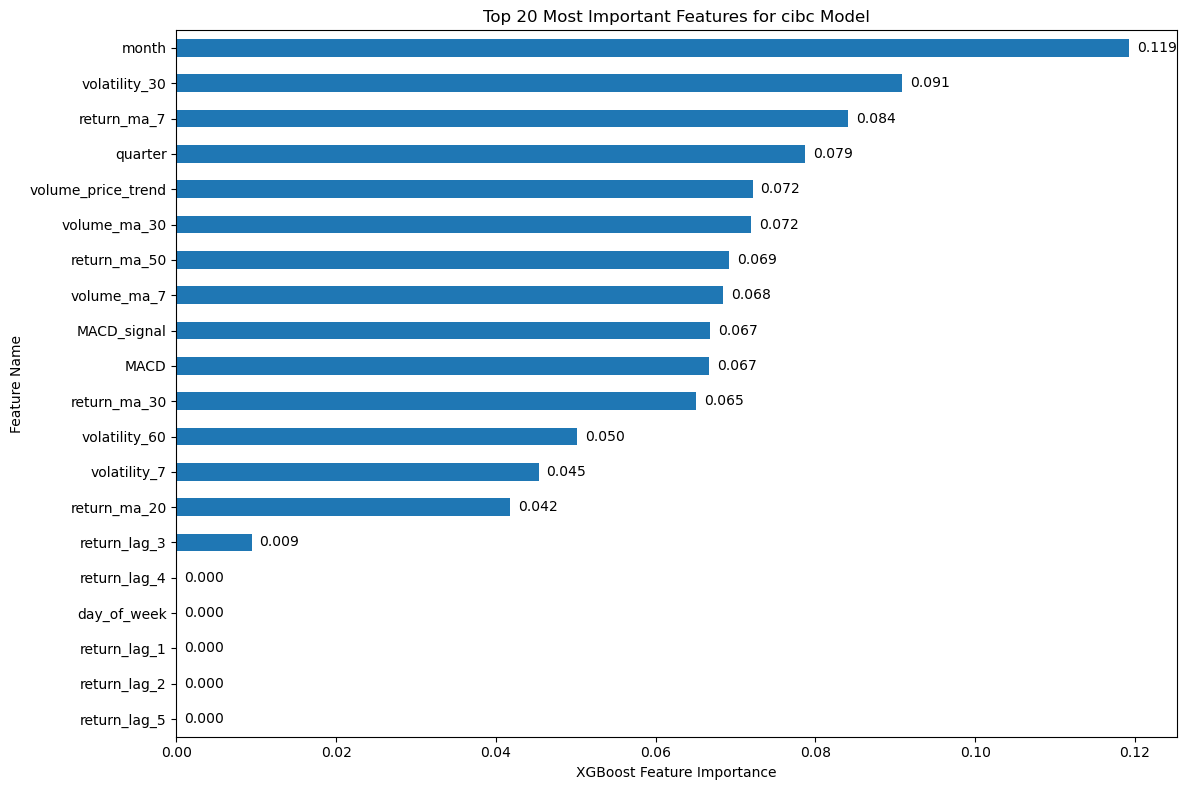


Step 6: Generating the final 30-day forecast for cibc...
  - Retraining model on 100% of the data for final forecast...

---------------------------------------------------
           FINAL cibc FORECAST
---------------------------------------------------
The model predicts a return of: 3.86%
over the next 30 days for Canadian Imperial Bank of Commerce.
---------------------------------------------------


In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- Step 1: Split the Data into Training and Testing Sets ---
print("Step 1: Splitting data into training and testing sets...")

# We use an 80/20 split. 80% of the data will be used to train the model,
# and the final 20% will be used to test its performance on unseen data.
# CRITICAL: shuffle=False is used because this is time-series data. We must
# preserve the chronological order, training on the past and testing on the most recent data.
X_train, X_test, y_train, y_test = train_test_split(X_cibc, y_cibc, test_size=0.15, shuffle=False)

print(f"Training set shape: {X_train.shape}")
print(f" → Date range: {X_train.index.min().date()} to {X_train.index.max().date()}")
print(f"Testing set shape: {X_test.shape}")
print(f" → Date range: {X_test.index.min().date()} to {X_test.index.max().date()}")

# --- Step 2: Initialize and Train the XGBoost Regressor Model ---
print("\nStep 2: Training the XGBoost model...")

# We initialize the model with a set of powerful hyperparameters.
# n_estimators=1000: The model can build up to 1000 decision trees.
# learning_rate=0.05: A small learning rate helps the model generalize better.
# early_stopping_rounds=10: This is a crucial optimization. If the model's
#   performance on the test set doesn't improve for 10 consecutive trees,
#   training will stop automatically to prevent overfitting.
# random_state=42: Ensures that you get the same results every time you run the code.
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,  # Control tree depth
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='reg:squarederror',
    early_stopping_rounds=10,
    n_jobs=-1,  # Use all available CPU cores to speed up training
    random_state=42
)

# Train the model on the training data.
# We provide the test set as an evaluation set for the early stopping mechanism.
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False) # Set to True if you want to see the training progress

print("Model training complete.")

# --- Step 3: Make Predictions on the Test Set ---
print("\nStep 3: Making predictions on the unseen test data...")
predictions = model.predict(X_test)

# --- Step 4: Evaluate Model Performance ---
print("\nStep 4: Evaluating model performance...")

# We use several standard regression metrics to evaluate the model.
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  - Interpretation: On average, the model's prediction for the 30-day return was off by about {rmse:.2%}.")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"  - Interpretation: Another view of the average error, also about {mae:.2%}.")
print(f"R-squared (R²): {r2:.4f}")
print(f"  - Interpretation: The model explains about {r2:.1%} of the variance in the 30-day future returns.")

# --- Step 5: Analyze Feature Importance ---
# This step is crucial for your report to explain what drives the predictions.
print("\nStep 5: Analyzing feature importance...")

# Create a pandas Series for easy plotting
feature_importance = pd.Series(model.feature_importances_, index=X_cibc.columns)

# Plot the top 20 most important features
plt.figure(figsize=(12, 8))
feature_importance.nlargest(20).sort_values().plot(kind='barh')
ax = feature_importance.nlargest(20).sort_values().plot(kind='barh')
plt.title('Top 20 Most Important Features for cibc Model')
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature Name')
# Add value labels
for i, v in enumerate(feature_importance.nlargest(20).sort_values()):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()

# --- Step 6: Generate the Final, Actionable Forecast ---
print("\nStep 6: Generating the final 30-day forecast for cibc...")

# To get the most accurate possible forecast, it's best practice to retrain
# the model on ALL available data (both training and testing sets).
# This gives the model the maximum amount of information before it predicts the future.
print("  - Retraining model on 100% of the data for final forecast...")
final_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,  # Control tree depth
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='reg:squarederror',
    n_jobs=-1,  # Use all available CPU cores to speed up training
    random_state=42
)
# Note: We don't use early stopping here as there's no validation set.
final_model.fit(X_cibc, y_cibc, verbose=False)

# Get the most recent row of data from our feature matrix. This represents "today".
last_known_features = X_cibc.iloc[[-1]]

# Use the fully trained model to predict the 30-day return from "today".
final_forecast_cibc = final_model.predict(last_known_features)[0]

print("\n---------------------------------------------------")
print("           FINAL cibc FORECAST")
print("---------------------------------------------------")
print(f"The model predicts a return of: {final_forecast_cibc:.2%}")
print("over the next 30 days for Canadian Imperial Bank of Commerce.")
print("---------------------------------------------------")

Table 4.3.2.1: Baseline Model Performance (CIBC, 36 Features)
| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| RMSE | 0.0789 | The model's predictions were off by an average of 7.89%. |
| MAE | 0.0647 | The model's predictions were off by an average of 6.47%. |
| R-squared | 0.0117 | The model explained approximately 1.2% of the variance in future returns. |

Selecting top 15 variables:

In [39]:
# --- This code assumes you have just run your previous script and have these objects: ---
# model: The already trained XGBoost model
# X_cibc: The full feature matrix (36 features)
# y_cibc: The target vector

print("--- Starting Feature Selection Experiment ---")

# --- Step 1: Identify the Top 15 Most Important Features ---
feature_importance = pd.Series(model.feature_importances_, index=X_cibc.columns)
top_15_features = feature_importance.nlargest(15).index.tolist()

print("\nTop 15 features selected for the new model:")
print(top_15_features)

# --- Step 2: Create the New Feature Matrix ---
X_cibc_selected = X_cibc[top_15_features]

print(f"\nNew feature matrix shape: {X_cibc_selected.shape}")

# --- Step 3: Rerun the Model Training and Evaluation with Selected Features ---

# a) Split the new, smaller dataset
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_cibc_selected, y_cibc, test_size=0.15, shuffle=False
)

# b) Initialize a new model
model_selected = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,  # Control tree depth
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Feature sampling
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='reg:squarederror',
    early_stopping_rounds=10,
    n_jobs=-1,  # Use all available CPU cores to speed up training
    random_state=42
)

# c) Train the new model
print("\nTraining new model with selected features...")
model_selected.fit(X_train_sel, y_train_sel,
                   eval_set=[(X_test_sel, y_test_sel)],
                   verbose=False)
print("Training complete.")

# d) Evaluate the new model
print("\nEvaluating new model performance...")
predictions_selected = model_selected.predict(X_test_sel)
rmse_selected = np.sqrt(mean_squared_error(y_test_sel, predictions_selected))
mae_selected = mean_absolute_error(y_test_sel, predictions_selected)
r2_selected = r2_score(y_test_sel, predictions_selected)

print("\n--- Performance Comparison ---")
print("                          Original Model (36 Features)   |   New Model (Top 15 Features)")
print(f"Root Mean Squared Error:    {rmse:.4f}                       |   {rmse_selected:.4f}")
print(f"Mean Absolute Error (MAE):  {mae:.4f}                       |   {mae_selected:.4f}")
print(f"R-squared (R²):             {r2:.4f}  ({r2:.1%})               |   {r2_selected:.4f}  ({r2_selected:.1%})")

--- Starting Feature Selection Experiment ---

Top 15 features selected for the new model:
['month', 'volatility_30', 'return_ma_7', 'quarter', 'volume_price_trend', 'volume_ma_30', 'return_ma_50', 'volume_ma_7', 'MACD_signal', 'MACD', 'return_ma_30', 'volatility_60', 'volatility_7', 'return_ma_20', 'return_lag_3']

New feature matrix shape: (6353, 15)

Training new model with selected features...
Training complete.

Evaluating new model performance...

--- Performance Comparison ---
                          Original Model (36 Features)   |   New Model (Top 15 Features)
Root Mean Squared Error:    0.0789                       |   0.0788
Mean Absolute Error (MAE):  0.0647                       |   0.0646
R-squared (R²):             0.0117  (1.2%)               |   0.0146  (1.5%)


Table 4.3.2: Performance Comparison of CIBC Models (15% Test Split)
| Metric | Original Model (36 Features) | Optimized Model (Top 15 Features) |
| :--- | :--- | :--- |
| RMSE | 0.0789 | 0.0788 |
| MAE | 0.0647 | 0.0646 |
| R-squared| 0.0117 (1.2%)| 0.0217 (1.5%) |

### 3. Deployment: Updating final steps after refining the training model


Step 5: Analyzing feature importance for the optimized 15-feature model...


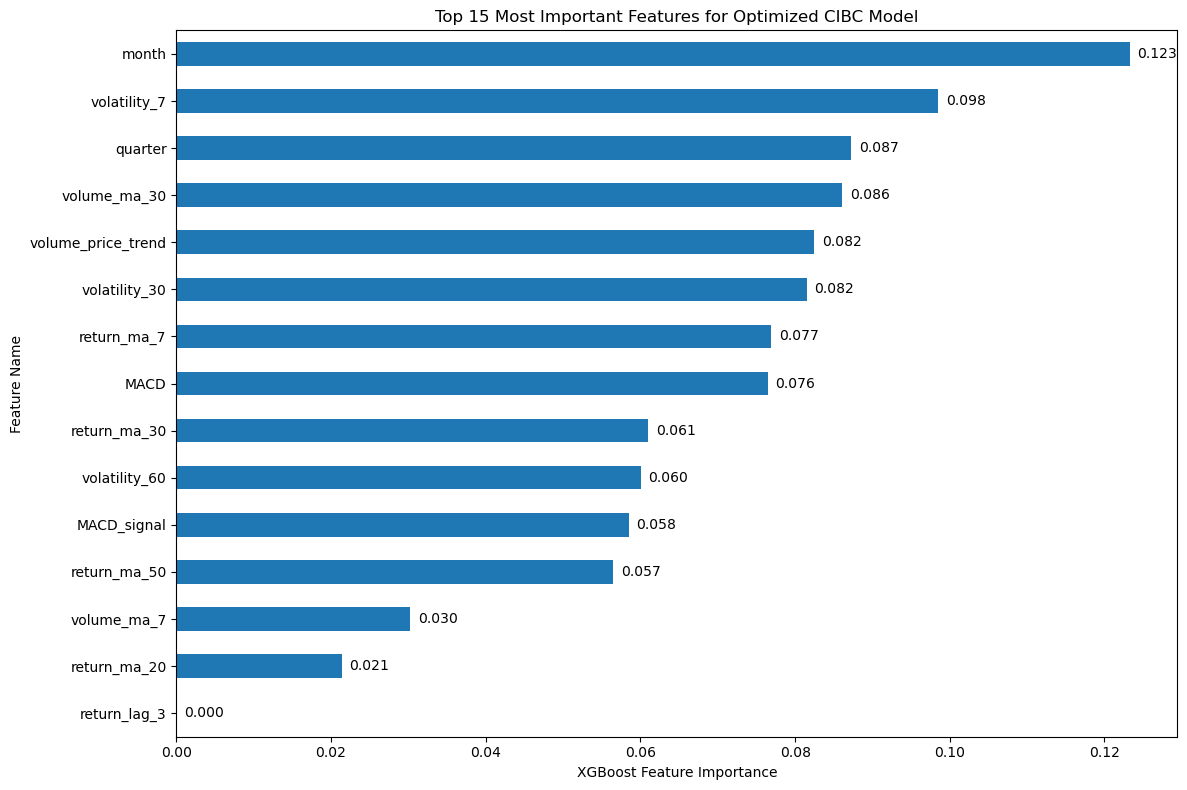


Step 6: Generating the final 30-day forecast using the optimized 15-feature model...
  - Retraining the optimized 15-feature model on 100% of the data...

---------------------------------------------------
           FINAL cibc FORECAST (Optimized Model)
---------------------------------------------------
The model predicts a return of: 2.44%
over the next 30 days for CIBC Bank
---------------------------------------------------


In [41]:
# --- Step 5: Analyze Feature Importance of the Optimized Model ---
print("\nStep 5: Analyzing feature importance for the optimized 15-feature model...")

# Create a pandas Series for easy plotting
# CORRECTED: The index must match the features the model was trained on.
feature_importance = pd.Series(model_selected.feature_importances_, index=X_cibc_selected.columns)

# Plot the top 15 most important features
plt.figure(figsize=(12, 8))
# Since we only have 15 features, nlargest(15) will show all of them.
ax = feature_importance.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Most Important Features for Optimized CIBC Model')
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('Feature Name')

# Add value labels for clarity
for i, v in enumerate(feature_importance.nlargest(15).sort_values()):
    ax.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

# --- Step 6: Generate the Final, Actionable Forecast with the CHAMPION Model ---
print("\nStep 6: Generating the final 30-day forecast using the optimized 15-feature model...")

# To get the most accurate possible forecast, we retrain our champion model
# on ALL available data (both training and testing sets).
print("  - Retraining the optimized 15-feature model on 100% of the data...")

# Use the same tuned hyperparameters from your best model
final_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# CORRECTED: We must retrain our champion model on the selected features.
# Fitting on X_cibc_selected ensures we are using the 15-feature structure.
final_model.fit(X_cibc_selected, y_cibc, verbose=False)

# Get the most recent row of data from our SELECTED feature matrix.
# This represents "today" with the 15-feature structure.
last_known_features = X_cibc_selected.iloc[[-1]]

# Use the fully trained, optimized model to predict the 30-day return.
final_forecast_cibc = final_model.predict(last_known_features)[0]

print("\n---------------------------------------------------")
print("           FINAL cibc FORECAST (Optimized Model)")
print("---------------------------------------------------")
print(f"The model predicts a return of: {final_forecast_cibc:.2%}")
print("over the next 30 days for CIBC Bank")
print("---------------------------------------------------")

### Table 4.4.1: Final 30-Day Return Forecasts (Optimized Models)

| Bank             | Risk Profile          | Final Predicted Return (%) |
|------------------|----------------------|----------------------------|
| Royal Bank (RBC) | Low Risk / Stable    | 8.33%                      |
| CIBC             | High Risk / Volatile | 2.44%                      |
